In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/TDAC_seq/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
# Create a folder to save plots
working_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20"
plot_dir = os.path.join("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/", "plot")
os.system("mkdir -p " + plot_dir)

# Create a dictionary for reference regions
ref_range_dict = {
    'HJR250_20': ('chr5', 180324459, 180334556)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR_250_20", 
    region_dict = ref_range_dict, 
    genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna", 
    fastq_file =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR250/HJR250_20/HJR250_20_merged.fastq.gz", 
    working_dir =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20"
)

# Load DddA bias model
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)



Loading reference genome
Extracting sequences for each locus


In [3]:
plot_range = np.arange(3500, 5500)
locus = "HJR250_20"

In [4]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)


Computing sequence bias


100%|██████████| 151187/151187 [04:49<00:00, 522.43it/s]


77624 reads aligned. 73563 reads unaligned


In [5]:
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_ddda_101024.pkl", "wb") as f:
    pickle.dump(ddda_data, f)

In [5]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_ddda_101024.pkl', 'rb') as f:
    ddda_data = pickle.load(f)

In [5]:
min_num=10000
undel_read_ids=np.random.choice(np.array(ddda_data.read_ids[locus]), min_num, replace=False)

In [6]:
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = undel_read_ids
)

100%|██████████| 10000/10000 [00:03<00:00, 3294.00it/s]
10000it [00:00, 1167679.29it/s]


In [7]:
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

In [9]:
selected_read_inds = undel_read_inds
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.zeros(len(undel_read_inds))
selection_dict = {"HJR250_20":selected_reads}

In [10]:
# Calculate nucleosome footprints for individual reads
footprints_dict_nuc = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [50], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_nuc = np.squeeze(np.array([i for i in footprints_dict_nuc[locus].values()]))
fp_nuc = -np.log10(fp_nuc)

Computing footprints for HJR250_20


100%|██████████| 2071/2071 [00:09<00:00, 208.34it/s]


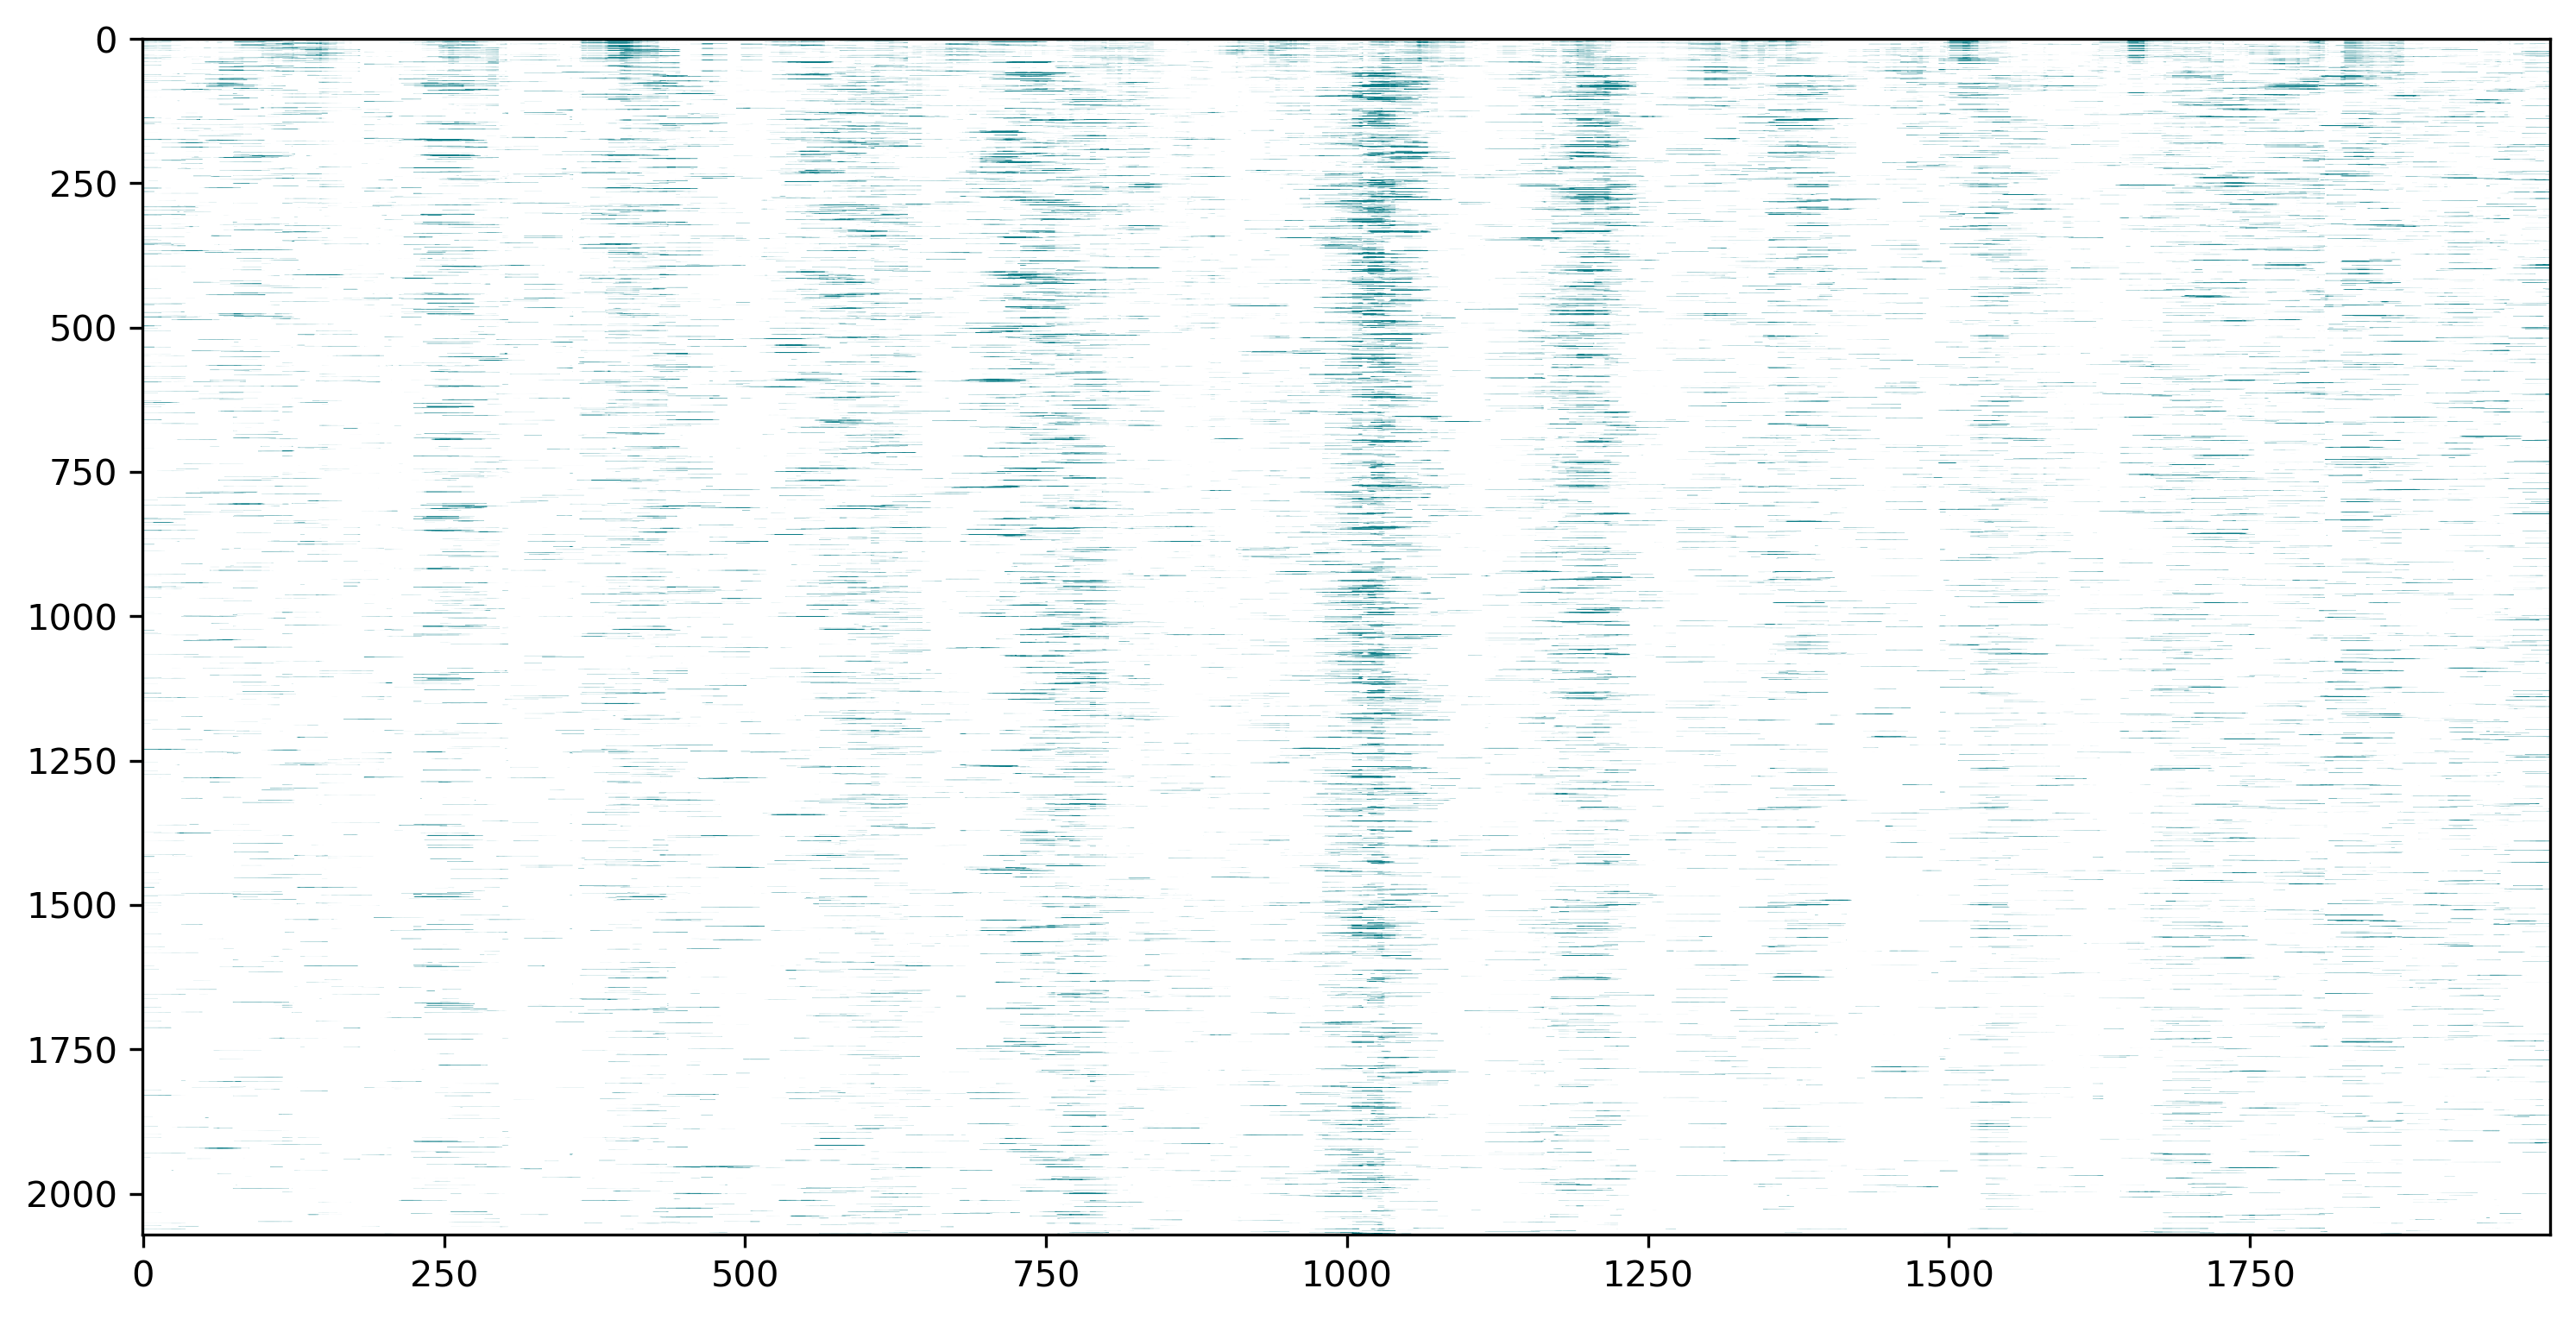

In [20]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])
plot_range = np.arange(3500, 5500)
fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.1, cmap=dark_green_cmap )

plt.show()

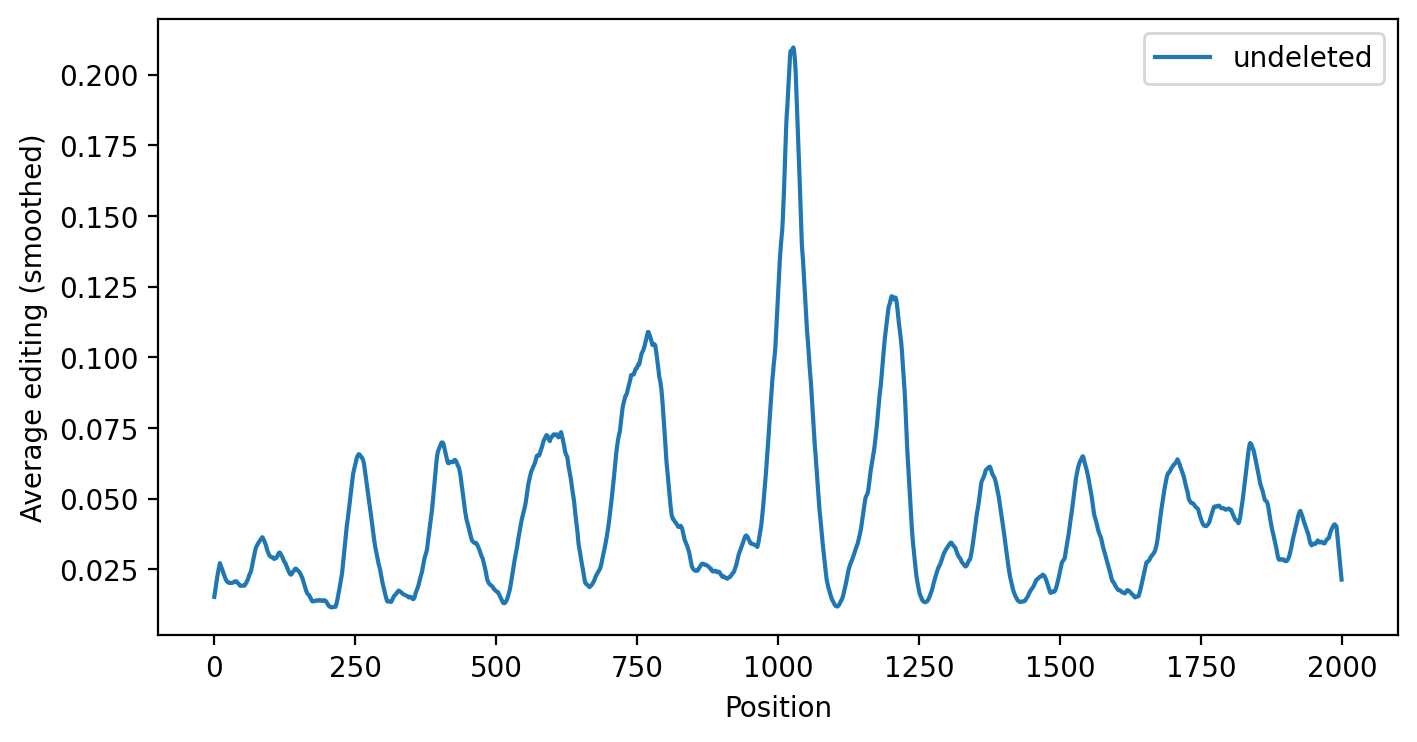

In [12]:
# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted_fp_nuc = np.mean(fp_nuc[selected_del_flags == 0, :][:, plot_range], axis = 0)
track_undeleted_fp_nuc = np.convolve(
    track_undeleted_fp_nuc, 
    np.ones(smooth_radius), 
    mode="same") / smooth_radius

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_undeleted_fp_nuc)), track_undeleted_fp_nuc, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.show()

In [13]:
# Calculate nucleosome footprints for individual reads
footprints_dict_TF = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [25], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_TF = np.squeeze(np.array([i for i in footprints_dict_TF[locus].values()]))
fp_TF = -np.log10(fp_TF)

Computing footprints for HJR250_20


100%|██████████| 2071/2071 [00:07<00:00, 280.65it/s]


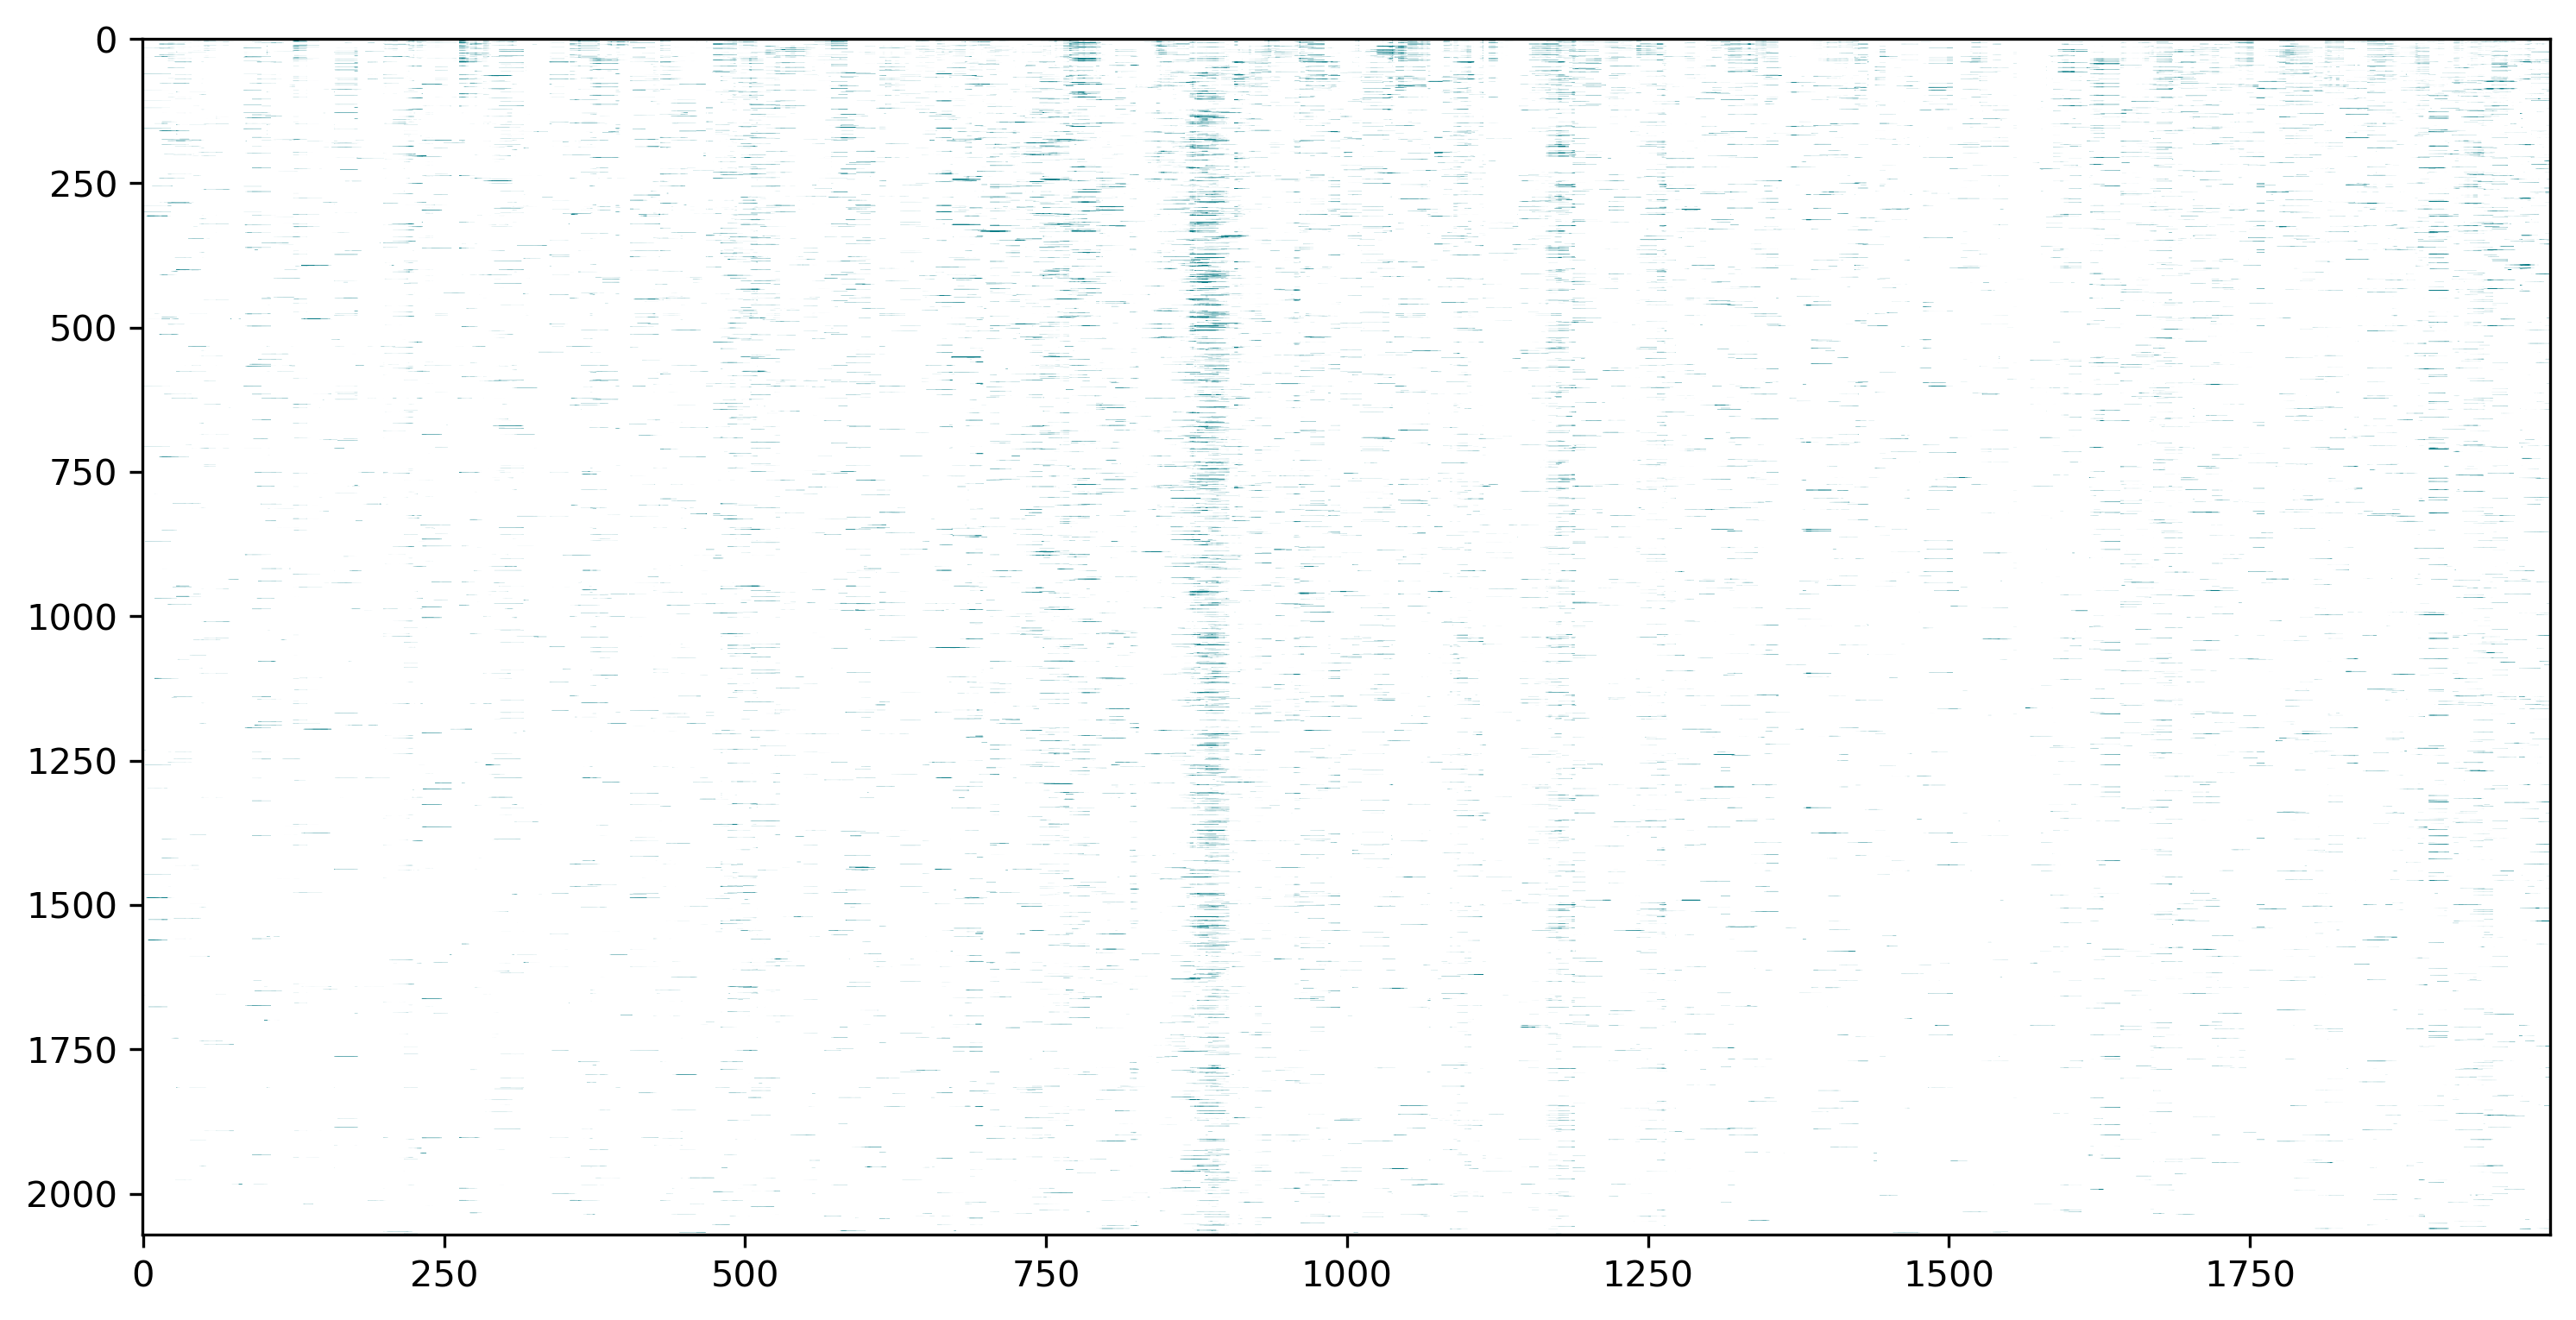

In [18]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])
plot_range = np.arange(3500, 5500)
fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax.imshow(fp_TF[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.1, cmap=dark_green_cmap)

plt.show()

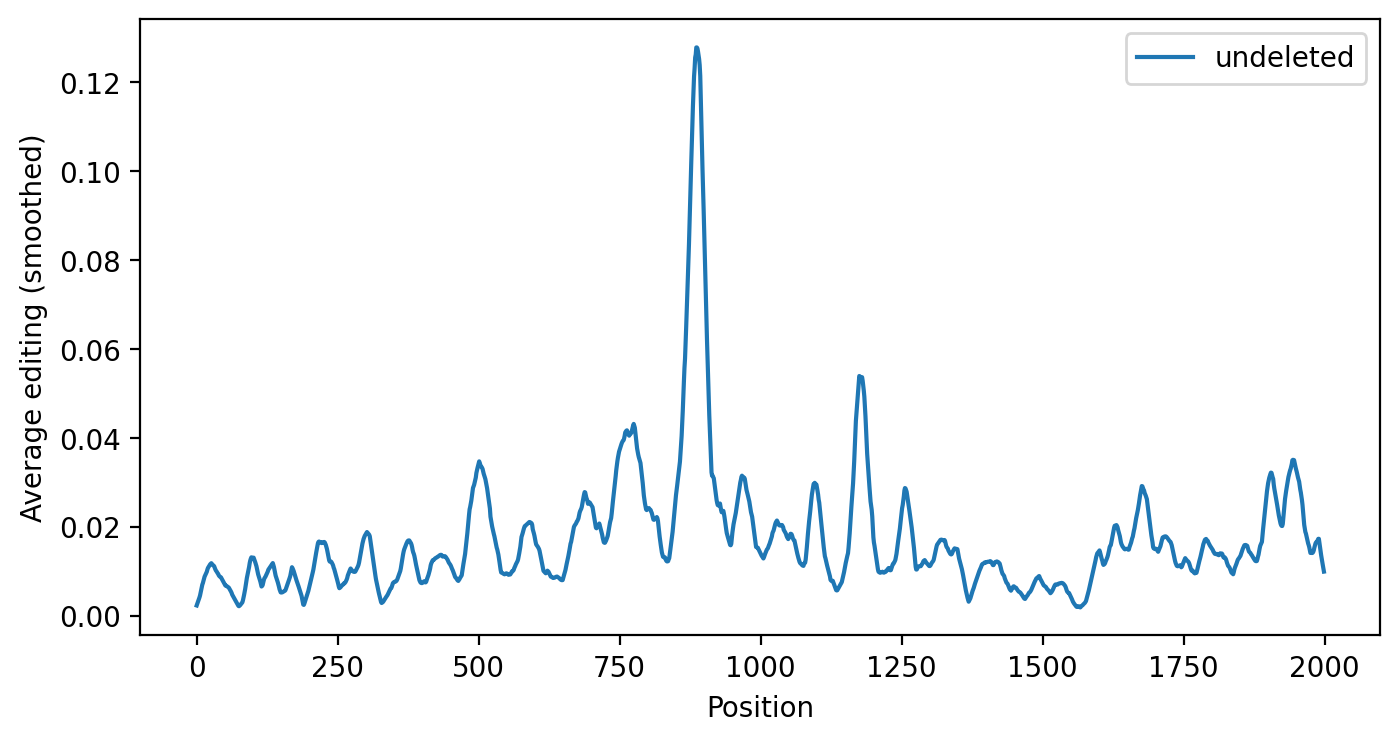

In [15]:
# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted_fp_TF = np.mean(fp_TF[selected_del_flags == 0, :][:, plot_range], axis = 0)
track_undeleted_fp_TF = np.convolve(
    track_undeleted_fp_TF, 
    np.ones(smooth_radius), 
    mode="same") / smooth_radius

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_undeleted_fp_TF)), track_undeleted_fp_TF, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.show()

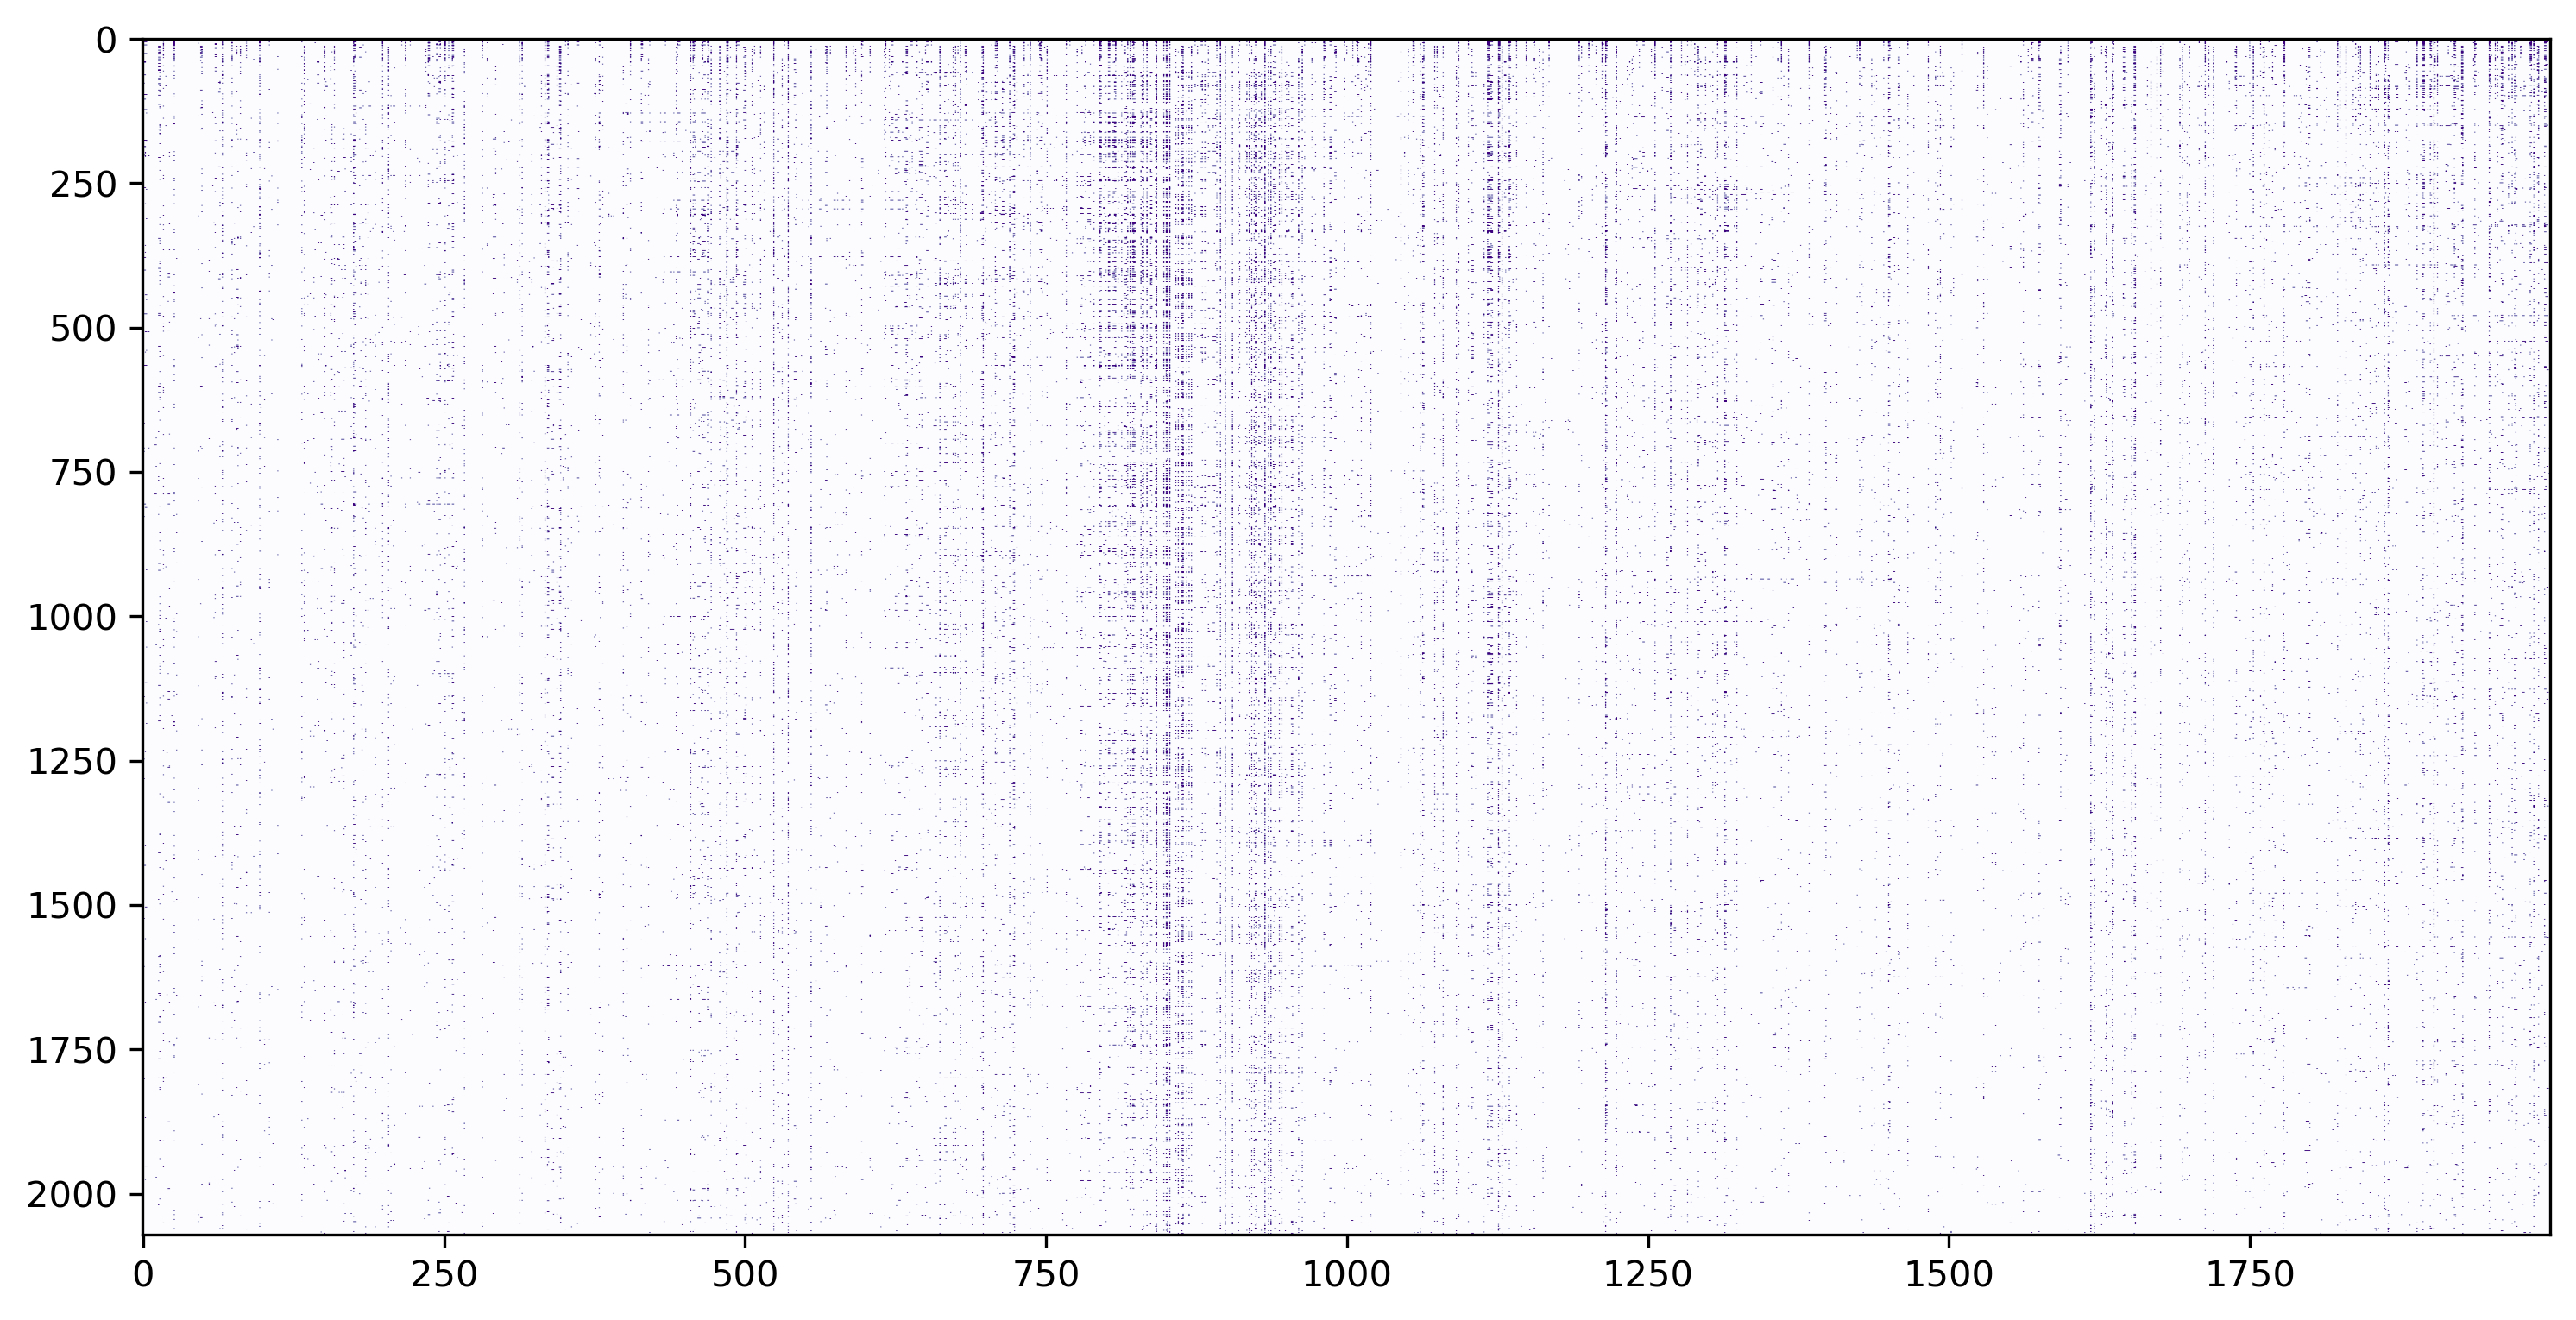

In [16]:
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

# Plot edits of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num)]
ax.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap="Purples")

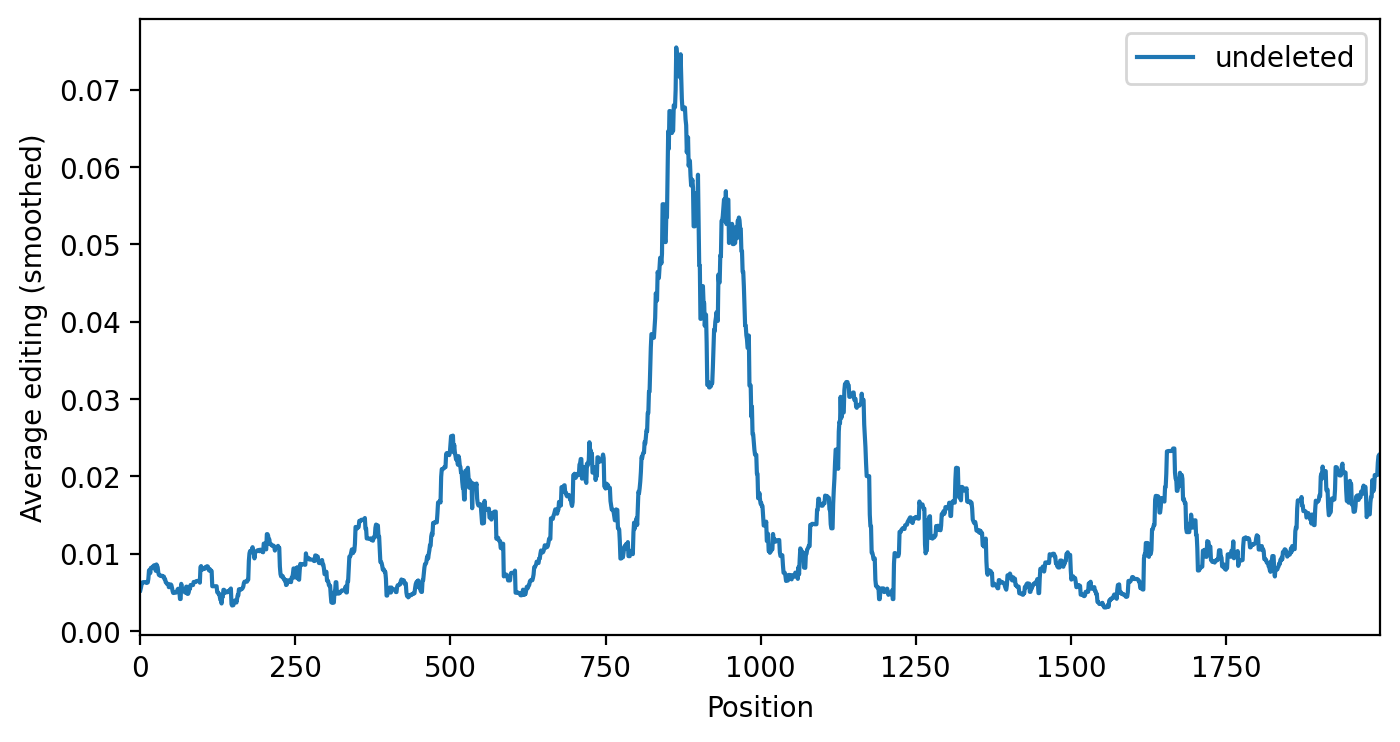

In [17]:
# Calculate average editing rate for each condition
track_undeleted_ac = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_undeleted_ac = np.convolve(track_undeleted_ac, np.ones(50))/50
track_undeleted_ac = track_undeleted_ac[plot_range]

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))

plt.plot(np.arange(len(track_undeleted_ac)), track_undeleted_ac, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.xlim(0, len(track_undeleted_ac) - 1)

plt.show()

In [31]:
   
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_MNase_x_values.pkl', 'rb') as f:
    MNase_x_values = pickle.load(f)
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_MNase_y_values.pkl', 'rb') as f:
    MNase_y_values = pickle.load(f)

with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_ATAC_x_values.pkl', 'rb') as f:
    ATAC_x_values = pickle.load(f)
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_ATAC_y_values.pkl', 'rb') as f:
    ATAC_y_values = pickle.load(f)
    
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_CTCF_x_values.pkl', 'rb') as f:
    CTCF_x_values = pickle.load(f)
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_20/HJR250_20_CTCF_y_values.pkl', 'rb') as f:
    CTCF_y_values  = pickle.load(f)

In [32]:
MNase_x_values =MNase_x_values[plot_range]
MNase_y_values =MNase_y_values[plot_range]
ATAC_x_values= ATAC_x_values[plot_range]
ATAC_y_values =  ATAC_y_values[plot_range]
CTCF_x_values= CTCF_x_values[plot_range]
CTCF_y_values =  CTCF_y_values[plot_range]

In [33]:
#sgRNA barplot
CTCF_motif_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
CTCF_motif_values = np.zeros_like(CTCF_motif_x_values)
CTCF_motif_values[(CTCF_motif_x_values >= 180328830) & (CTCF_motif_x_values < 180328850)] = 3  # Adjust indices as needed
CTCF_motif_values_region=CTCF_motif_values[plot_range]
CTCF_motif_x_values_region=CTCF_motif_x_values[plot_range]

In [34]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])

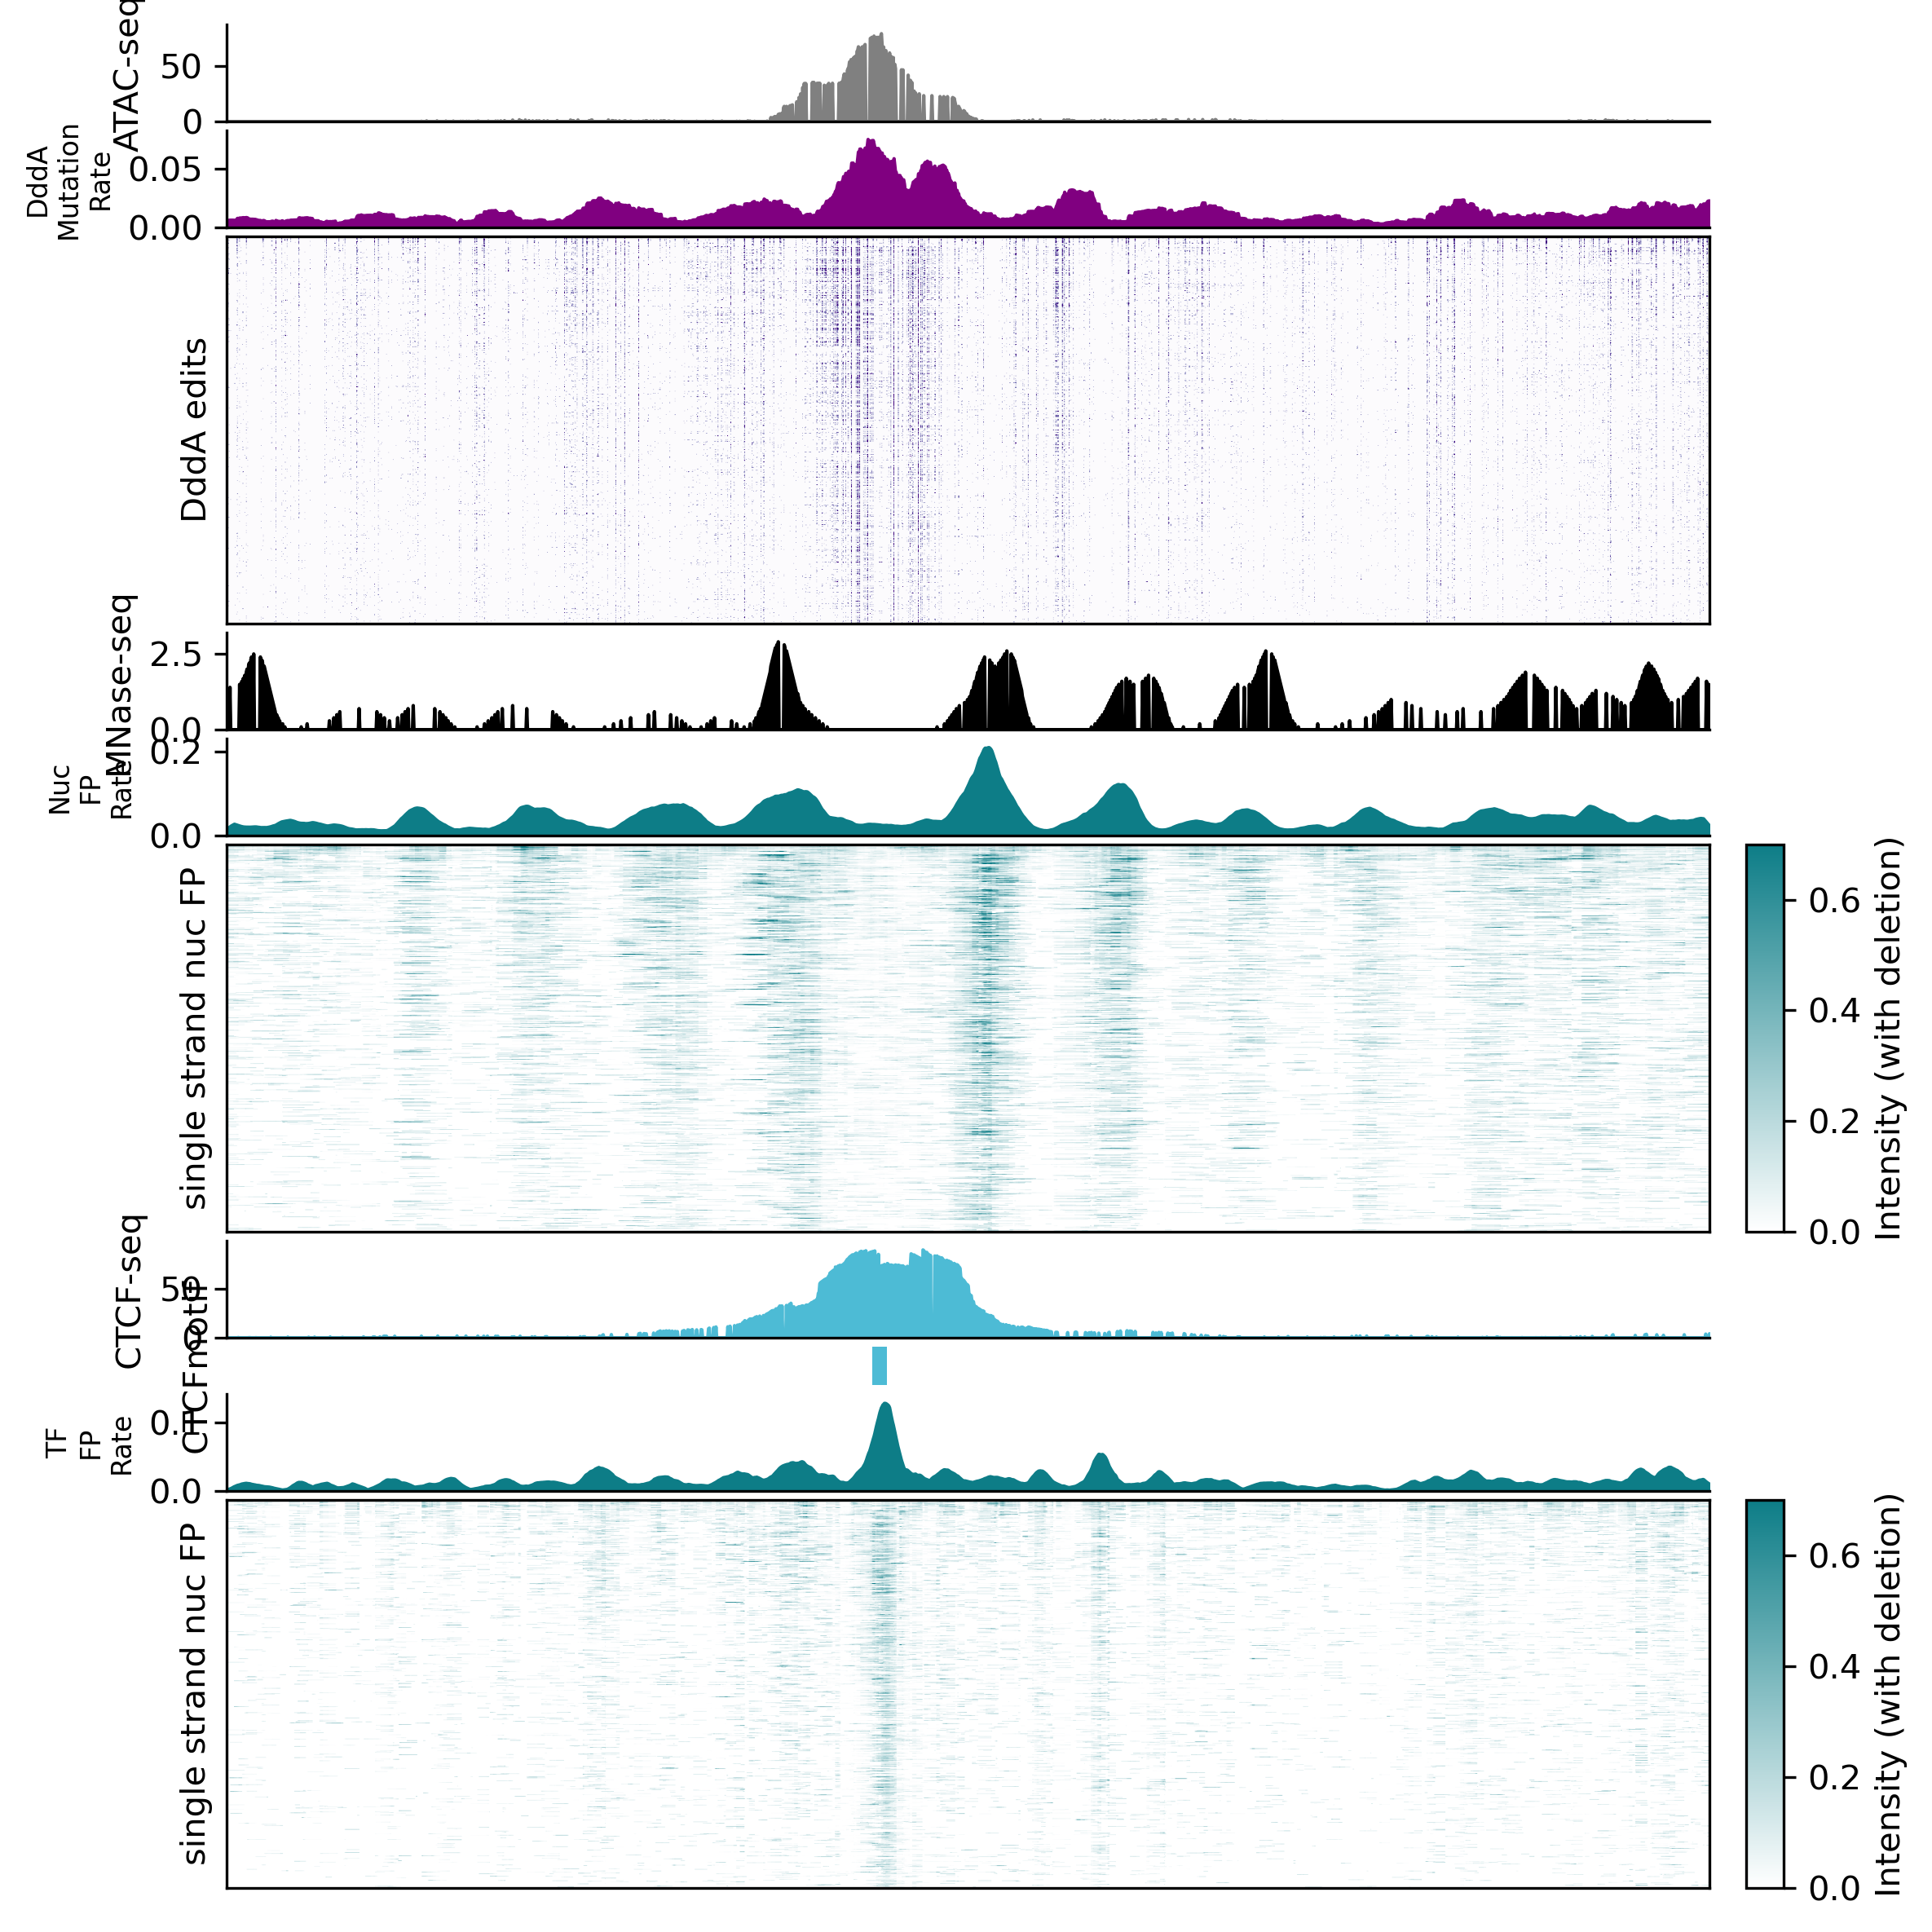

In [35]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(dpi=300, figsize=(8, 8))
gs = gridspec.GridSpec(10, 2,width_ratios=[20, 0.5], height_ratios=[0.5, 0.5, 2, 0.5, 0.5, 2, 0.5, 0.2, 0.5, 2])

# First subplot
ax1 = plt.subplot(gs[0,0])
ax1.fill_between(ATAC_x_values, ATAC_y_values, color='Grey', alpha=1)
ax1.set_xlim([ATAC_x_values.min(), ATAC_x_values.max()])
ax1.set_ylim([0, max(ATAC_y_values) * 1.1])
ax1.set_xticks([])  # Remove x-axis ticks
ax1.set_xlabel('')
ax1.set_ylabel('ATAC-seq')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Second subplot
ax2 = plt.subplot(gs[1,0])
x_values = np.arange(len(track_undeleted_ac))
ax2.fill_between(x_values, track_undeleted_ac, color='purple', alpha=1)
ax2.set_xlim([x_values.min(), x_values.max()])
ax2.set_ylim([0, max(track_undeleted_ac) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('DddA\nMutation\nRate', fontsize=8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Third subplot
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]

ax3 = plt.subplot(gs[2,0])
ax3.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=0.5, vmin=0, cmap='Purples')
ax3.set_ylabel('DddA edits')
ax3.set_xticks([])  # Remove x-axis ticks
ax3.set_yticks([])  # Remove y-axis ticks
ax3.set_xlabel('')

# Fourth subplot
ax4 = plt.subplot(gs[3,0])
ax4.fill_between(MNase_x_values, MNase_y_values, color='Black', edgecolor='Black', alpha=1)
ax4.set_xlim([MNase_x_values.min(), MNase_x_values.max()])
ax4.set_ylim([0, max(MNase_y_values) * 1.1])
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_xlabel('')
ax4.set_ylabel('MNase-seq')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Fifth subplot
ax5 = plt.subplot(gs[4,0])
x_values = np.arange(len(track_undeleted_fp_nuc))
ax5.fill_between(x_values, track_undeleted_fp_nuc, color='#0d7d87', alpha=1)
ax5.set_xlim([x_values.min(), x_values.max()])
ax5.set_ylim([0, max(track_undeleted_fp_nuc) * 1.1])
ax5.set_xticks([])  # Remove x-axis ticks
ax5.set_xlabel('')
ax5.set_ylabel('Nuc\nFP\nRate', fontsize=8)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

# Sixth subplot
ax6 = plt.subplot(gs[5,0])
im6=ax6.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap=dark_green_cmap)
ax6.set_ylabel('single strand nuc FP')
ax6.set_xticks([])  # Remove x-axis ticks
ax6.set_yticks([])  # Remove y-axis ticks
ax6.set_xlabel('')

cbar6 = fig.add_subplot(gs[5, 1])
fig.colorbar(im6, cax=cbar6)
cbar6.set_ylabel('Intensity (with deletion)')

# Seventh subplot
ax7 = plt.subplot(gs[6,0])
ax7.fill_between(CTCF_x_values, CTCF_y_values, color='#4dbbd5', edgecolor='#4dbbd5', alpha=1)
ax7.set_xlim([CTCF_x_values.min(), CTCF_x_values.max()])
ax7.set_ylim([0, max(CTCF_y_values) * 1.1])
ax7.set_xticks([])  # Remove x-axis ticks
ax7.set_xlabel('')
ax7.set_ylabel('CTCF-seq')
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)

# Eighth subplot
ax8 = plt.subplot(gs[7,0])
ax8.bar(CTCF_motif_x_values_region, CTCF_motif_values_region, color='#4dbbd5', alpha=1, width=1.0)
ax8.set_xlim([CTCF_motif_x_values_region.min(), CTCF_motif_x_values_region.max()])
ax8.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax8.set_xticks([])  # Remove y-axis ticks for the bar plot
ax8.set_yticks([])  # Remove y-axis ticks for the bar plot
ax8.set_ylabel('CTCFmotif')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.spines['bottom'].set_visible(False)
ax8.spines['left'].set_visible(False)


# Ninth subplot
ax9 = plt.subplot(gs[8,0])
x_values = np.arange(len(track_undeleted_fp_TF))
ax9.fill_between(x_values, track_undeleted_fp_TF, color='#0d7d87', alpha=1)
ax9.set_xlim([x_values.min(), x_values.max()])
ax9.set_ylim([0, max(track_undeleted_fp_TF) * 1.1])
ax9.set_xticks([])  # Remove x-axis ticks
ax9.set_xlabel('')
ax9.set_ylabel('TF\nFP\nRate', fontsize=8)
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)


# Tenth subplot
ax10 = plt.subplot(gs[9,0])
im10=ax10.imshow(fp_TF[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap=dark_green_cmap)
ax10.set_ylabel('single strand nuc FP')
ax10.set_xticks([])  # Remove x-axis ticks
ax10.set_yticks([])  # Remove y-axis ticks
ax10.set_xlabel('')

cbar10 = fig.add_subplot(gs[9, 1])
fig.colorbar(im10, cax=cbar10)
cbar10.set_ylabel('Intensity (with deletion)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)

#plt.savefig(os.path.join(plot_dir, "HJR250_20_accessibility_FP_scale.pdf"))
plt.show()